In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from cartopy import crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

import matplotlib.path as mpath
import matplotlib.axes as maxes
from mpl_toolkits.axes_grid1 import make_axes_locatable


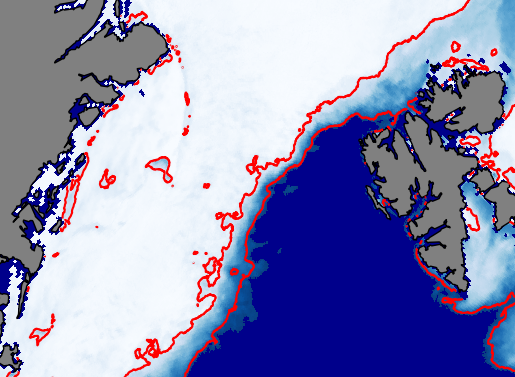

In [3]:
VELOX_nav = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_unified_data/unified_velox_nadir_Filter_05.nc')
SIC = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_unified_data/amsr_modis_sic.nc')

def polarCentral_set_latlim(lat_lims, ax):
    ax.set_extent([-18, 18, lat_lims[0], lat_lims[1]], ccrs.PlateCarree())
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)



bbox = [-21.093750,70.801040,20.523438,81.608341]


SIC_sel = SIC.sel(x=slice(bbox[0],bbox[2]),y=slice(bbox[3],bbox[1])).mean(dim='time')
SIC_sel = SIC.mean(dim='time')

crs = ccrs.NorthPolarStereo()

ds_miz = SIC_sel.where((SIC_sel['z'] > 5) & (SIC_sel['z'] < 101))

fig, ax = plt.subplots(subplot_kw={'projection': crs})
#ax.set_facecolor('darkblue')


cmap = plt.get_cmap('Blues_r')
cmap.set_bad('darkblue')

polarCentral_set_latlim([75, 82], ax)

#ds_miz.z.plot(col='time', col_wrap=4, cmap='Blues_r')
im = ds_miz.z.plot(ax=ax, 
            transform=ccrs.PlateCarree(),
            cmap=cmap, 
            vmin=0, 
            vmax=100,
            add_colorbar=False
            )


ds_miz.z.plot.contour(levels=[15, 85], colors='r', transform=ccrs.PlateCarree(), ax=ax)


# divider = make_axes_locatable(ax)

# cax = divider.append_axes('right', size='5%', axes_class=maxes.Axes)
# cb = fig.colorbar(im, cax=cax, orientation='vertical', label='Sea Ice Concentration [%]')

ax.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='gray')

#ax.coastlines(resolution='50m')
#plt.show()

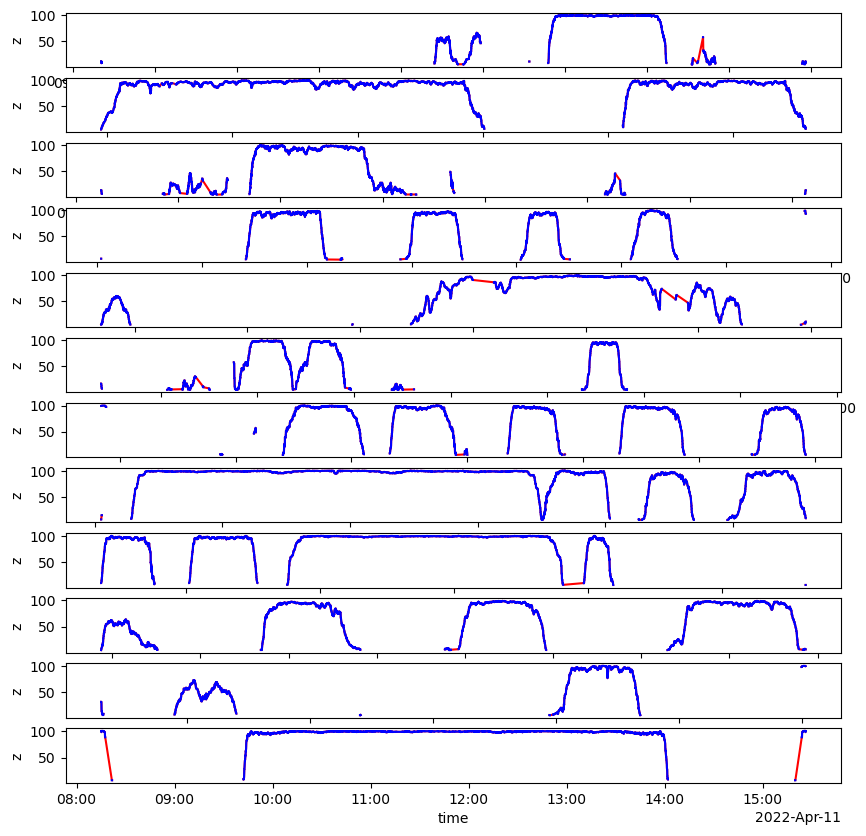

In [4]:
x = VELOX_nav['lon']
y = VELOX_nav['lat']

# Create a mask for the data

dsz = ds_miz['z'].sel(y=y, x=x, method='nearest')
dates = np.unique(dsz.time.dt.strftime('%Y-%m-%d').values)

fig, axs = plt.subplots(len(dates), 1, figsize=(10, 10), )
for i, date in enumerate(dates):
    axs[i].set_title(date)

    dsz.sel(time=date).interpolate_na(dim='time', max_gap=pd.Timedelta(minutes=12)).plot(ax=axs[i], c='r')
    dsz.sel(time=date).plot(ax=axs[i], c='b')


In [9]:
VELOX_nav['sic'] = dsz
(~VELOX_nav.sic.isnull()).sum()

<xarray.DataArray 'sic' ()>
array(119814)

In [6]:
### WE DONT NEED NO ITERATION ... dum tz tada

# from tqdm import tqdm

# mask = np.zeros(len(VELOX_nav.time))

# for i in tqdm(range(len(VELOX_nav.time))):
    
#     date = VELOX_nav.time[i].dt.strftime('%Y-%m-%d').values
#     lat = VELOX_nav.lat[i].values
#     lon = VELOX_nav.lon[i].values

#     ice_edge = ds_miz

#     sel = ice_edge['z'].sel(y=lat, x=lon, method='nearest')

#     mask[i] = sel.values

In [10]:
VELOX_nav['miz_mask'] = xr.DataArray(dsz.values, dims='time', coords={'time':VELOX_nav.time})

In [11]:
### import the cloud mask

cloud_mask = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_unified_data/unified_surface_mask.nc')['mask']
VELOX_nav['cloud_mask'] = cloud_mask

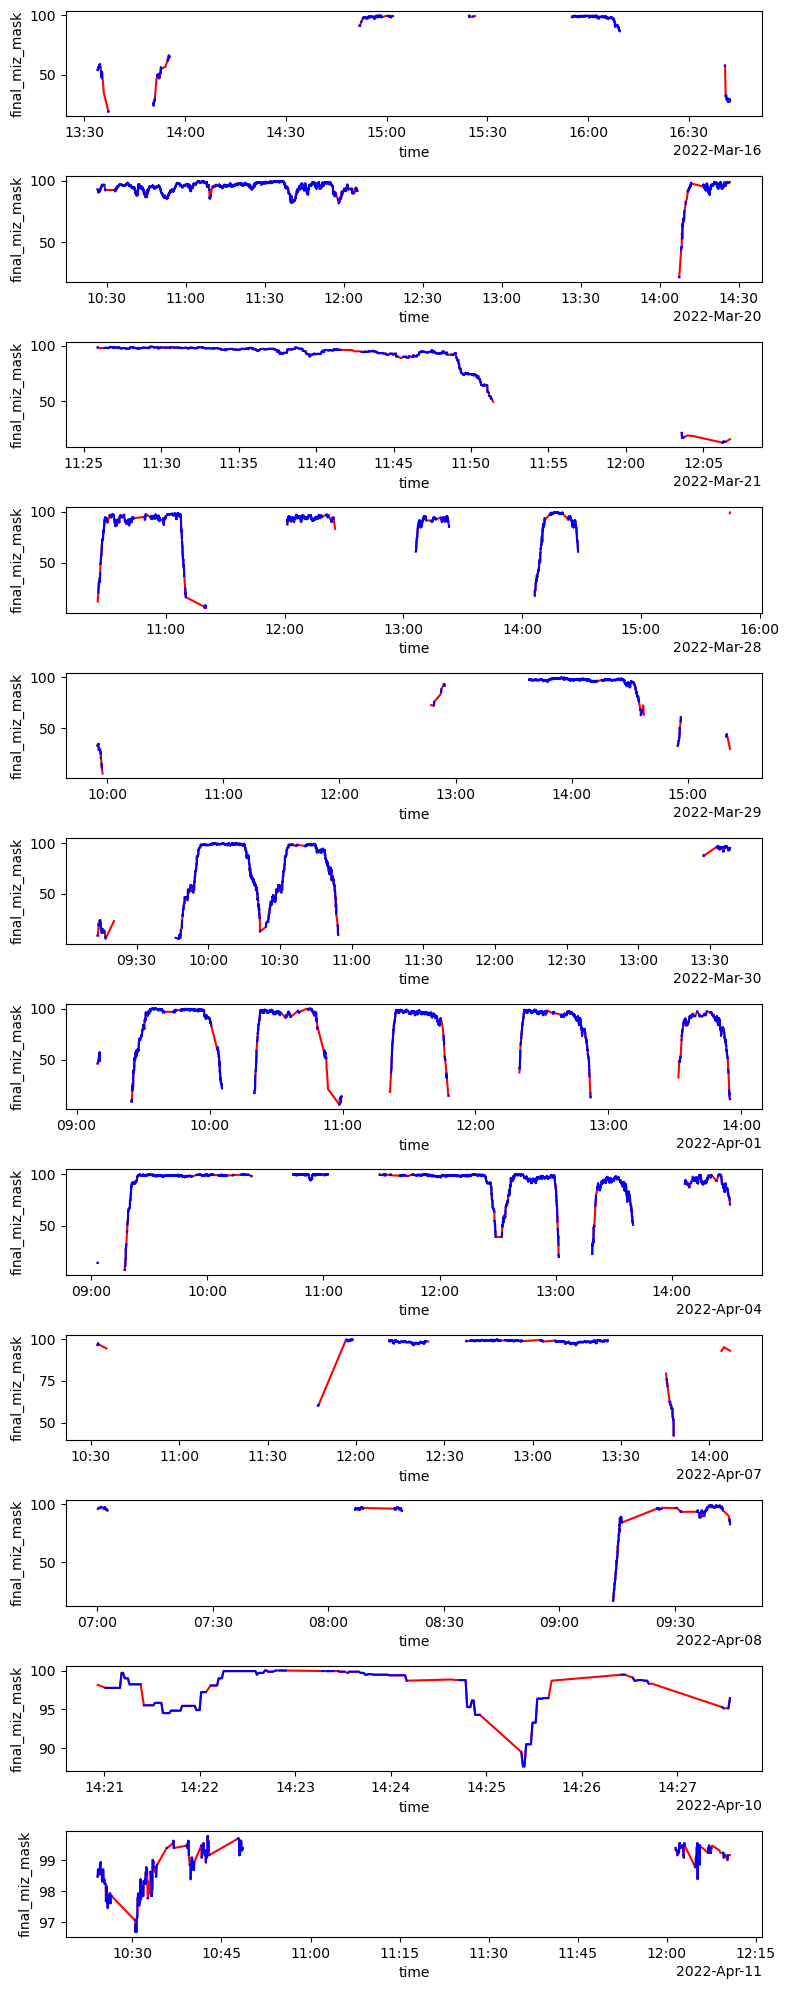

In [12]:
VELOX_nav['final_mask'] = (VELOX_nav['cloud_mask'] == 2) & ~np.isnan(VELOX_nav['miz_mask']) 
VELOX_nav['final_mask'] = VELOX_nav['final_mask'].where(VELOX_nav['final_mask'], np.nan)

VELOX_nav['final_miz_mask'] = VELOX_nav['final_mask'] * VELOX_nav['miz_mask']

fig, axs = plt.subplots(len(dates), 1, figsize=(8, 20))

for i, date in enumerate(dates):
    axs[i].set_title(date)
    VELOX_nav['final_miz_mask'].interpolate_na(dim='time', max_gap=pd.Timedelta(minutes=12)).sel(time=date).plot(ax=axs[i], c='r')
    VELOX_nav['final_miz_mask'].sel(time=date).plot(ax=axs[i], c='b')

VELOX_nav['final_miz_mask'] = VELOX_nav['final_miz_mask'].interpolate_na(dim='time', max_gap=pd.Timedelta(minutes=1))

plt.tight_layout()

In [13]:
VELOX_nav.final_miz_mask

<xarray.DataArray 'final_miz_mask' (time: 332919)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 2022-03-16T08:48:54 ... 2022-04-11T15:30:21
    x        (time) float64 20.33 20.33 20.33 20.33 ... 19.61 19.61 19.61 19.61
    y        (time) float64 67.82 67.82 67.82 67.82 ... 68.97 68.97 68.97 68.97

In [14]:
timesteps = VELOX_nav.time[VELOX_nav.final_miz_mask.notnull()]

df_time = pd.DataFrame(timesteps.values, columns=['time'])

print(df_time)

#df_time.to_csv('../../data/velox_timesteps_in_miz.csv', index=False)

                     time
0     2022-03-16 13:34:00
1     2022-03-16 13:34:01
2     2022-03-16 13:34:02
3     2022-03-16 13:34:03
4     2022-03-16 13:34:04
...                   ...
47000 2022-04-11 12:10:34
47001 2022-04-11 12:10:35
47002 2022-04-11 12:10:36
47003 2022-04-11 12:10:37
47004 2022-04-11 12:10:38

[47005 rows x 1 columns]


In [29]:
### 

t1 = pd.date_range('2022-03-20T10:35:00', '2022-03-20T10:50:00', freq='1s')
t2 = pd.date_range('2022-03-20T11:20:00', '2022-03-20T11:26:00', freq='1s')
t3 = pd.date_range('2022-03-21T11:39:00', '2022-03-21T11:44:00', freq='1s')
t4 = pd.date_range('2022-03-28T10:28:00', '2022-03-28T11:05:00', freq='1s')
t5 = pd.date_range('2022-03-28T13:13:30', '2022-03-28T13:21:30', freq='1s')
t6 = pd.date_range('2022-03-28T14:12:30', '2022-03-28T14:27:00', freq='1s')
t7 = pd.date_range('2022-03-29T14:27:00', '2022-03-29T14:37:30', freq='1s')
t8 = pd.date_range('2022-03-30T09:46:30', '2022-03-30T09:52:00', freq='1s')
t9 = pd.date_range('2022-04-01T09:25:00', '2022-04-01T09:32:30', freq='1s')
t10 = pd.date_range('2022-04-01T10:21:00', '2022-04-01T10:54:00', freq='1s')
t11 = pd.date_range('2022-04-01T11:22:30', '2022-04-01T11:43:30', freq='1s')
t12 = pd.date_range('2022-04-01T12:20:00', '2022-04-01T12:51:00', freq='1s')
t13 = pd.date_range('2022-04-01T13:36:00', '2022-04-01T13:52:30', freq='1s')
t14 = pd.date_range('2022-04-04T09:18:30', '2022-04-04T09:23:30', freq='1s')
t15 = pd.date_range('2022-04-04T12:24:00', '2022-04-04T13:01:00', freq='1s')
t16 = pd.date_range('2022-04-04T13:19:30', '2022-04-04T13:40:00', freq='1s')
t17 = pd.date_range('2022-04-04T14:08:00', '2022-04-04T14:30:00', freq='1s')
t18 = pd.date_range('2022-04-08T09:22:00', '2022-04-08T09:40:00', freq='1s')

list_of_timesteps = []
for i, t in enumerate([t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, t11, t12, t13, t14, t15, t16, t17, t18]):
    
    list_of_timesteps.append(pd.DataFrame(t, columns=['time']))

df_time = pd.concat(list_of_timesteps)

print(len(df_time))


18798


In [34]:
df_time.to_csv('../../data/velox_timesteps_in_miz_v1.csv', index=False)